# Calcium Imaging

Neurons consist of three basic parts: a soma (cell body, where the nucleus is located), an axon (the part that projects to other neurons), and dendrites (the part that receive input from other neurons). While we can directly record the electrical activity at the soma by using a variety of methods, because of the size of the dendrites we have to employ other techniques to estimate activity in these structures. One such technique is to use calcium, which is a highly regulated ion (it's concentration outside the cell vs. inside the cell is on the order of 20000 : 1, in comparison to sodium, for example, which is about 10 : 1), as a proxy for activity. 

We do this by filling the cell with a dye that can be excited with a laser (i.e. it will re-emit light after being hit with a laser spot). In pariticular, the dye is one such that the amount of light it re-emits is dependent upon whether it is bound to calcium. When a part of a dendrite becomes active, channels open that let calcium into the cell. This calcium binds to the dye, which then will either increase or decrease (depending on the dye) the amount of light the dye is emitting. Since the background calcium is very low, and only increases when that portion of the dendrite becomes active, we can use this change in emitted light to measure activity in that dendrite. 

In the experiment presented below we are taking scans with a laser through a region of dendrite and measuring the amount of calcium that enters the dendrite when we activate an excitatory synapse within that region of dendrite. 

In [2]:
import os
import sys
from glob import glob
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
sys.path.append('../../neurphys/neurphys/')
import pv_import as pvi
import calcium as clm
import utilities as util

%matplotlib inline

In [3]:
folder_list = sorted(glob('./data/08.05.15/*Cell2*LS*'))
folder_list

['./data/08.05.15/Cell2-LS-001',
 './data/08.05.15/Cell2-LS-002',
 './data/08.05.15/Cell2-LS-003',
 './data/08.05.15/Cell2-LS-004',
 './data/08.05.15/Cell2-LS-005',
 './data/08.05.15/Cell2-LS-006',
 './data/08.05.15/Cell2-LS-007',
 './data/08.05.15/Cell2-LS-008',
 './data/08.05.15/Cell2-LS-009',
 './data/08.05.15/Cell2-LS-010',
 './data/08.05.15/Cell2-LS-011',
 './data/08.05.15/Cell2-LS-012']

We have a series of data files that consist of both the imaging data, which has been converted from the raw tiffs to a csv file containing the fluorescence values (in arbitrary units, AU), as well as the associated electrical recordings (also contained in a separate csv file).

In [4]:
df_vr_list = [pvi.import_folder(folder)["voltage recording"] for folder in folder_list]
df_vr_list = [util.baseline(df, 5, 6) for df in df_vr_list]
df_ls_list = [pvi.import_folder(folder)["linescan"] for folder in folder_list]

Plotting a subset of these files...

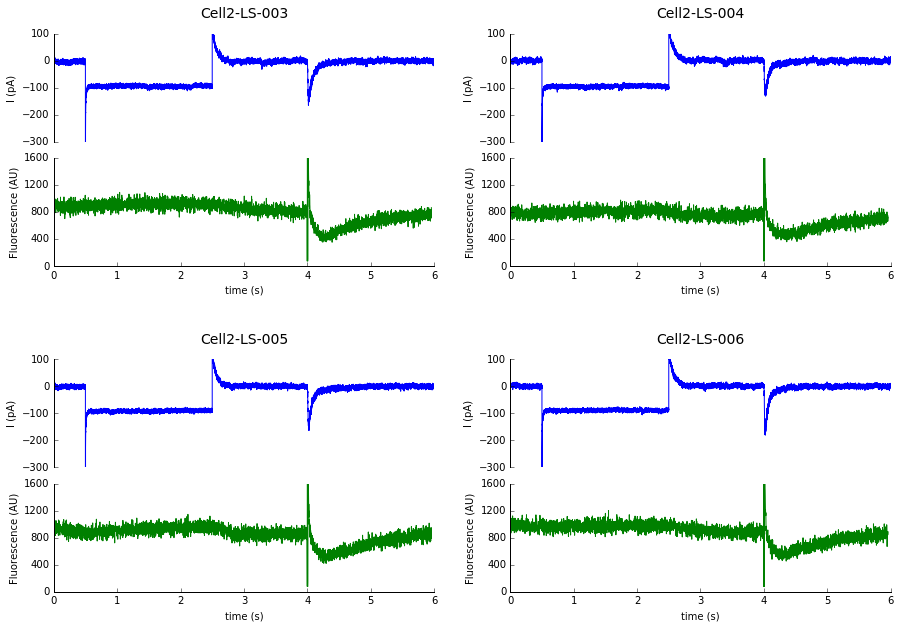

In [5]:
fig = plt.figure(figsize=(15, 10))
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.4)

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i], 
                                             wspace=0.1, hspace=0.15)
    
    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        if j == 0:
            x = df_vr_list[i+2]['Time']
            y = df_vr_list[i+2]['Primary']
            ax.plot(x, y)
            ax.set_title(os.path.split(folder_list[i+2])[-1], 
                         y = 1.1, fontsize=14)
            ax.set_ylabel('I (pA)')
            ax.set_ylim(-300, 100)
            clean_plot(ax, True)
        else:
            x = df_ls_list[i+2]['Prof 1 Time']
            y = df_ls_list[i+2]['Prof 1']
            ax.plot(x, y, 'g')
            ax.set_ylabel('Fluorescence (AU)')
            ax.set_xlabel('time (s)')
            ax.set_ylim(0, 1500)
            clean_plot(ax)
        fig.add_subplot(ax)

What we can see above is 4 plots of 4 different runs where we stimulate a synapse (at time = 4 sec) and can see both a resulting current as well as a calcium signal (the sharp event at time = 4 sec is an artifact of the stimulus being delivered). With this particular dye, the fluorescence is decreased as a result of calcium binding to the dye (we call this quenching). 

You will also notice that prior to the stimulus there is a large square-shaped step. We do this to generate an FMax value, which is important for the calculation below. FMax (i.e. maximum fluorescence) is the point where the calcium in the cell is as close to 0 as it can be (again, because the dye's fluorescence is inversely related to calcium concentration). 

In [6]:
for ls_df in df_ls_list:
    ls_df['Prof 1'] = util.simple_smoothing(ls_df['Prof 1'].values, 9)
    ls_df['ca_conc'] = clm.calc_ca_conc(ls_df, profile_num=1, f0_start=1.65, f0_end=2.4, 
                                        kd=120, background=80, rf=22, rf_real=18)

Based on the properties of the dye, as well as the experimentally determined FMax value (which is calculated from the average fluorescence value over the region defined as f0), we are able to calculate a rough approximation of the concentration of calcium in the dendrite. 

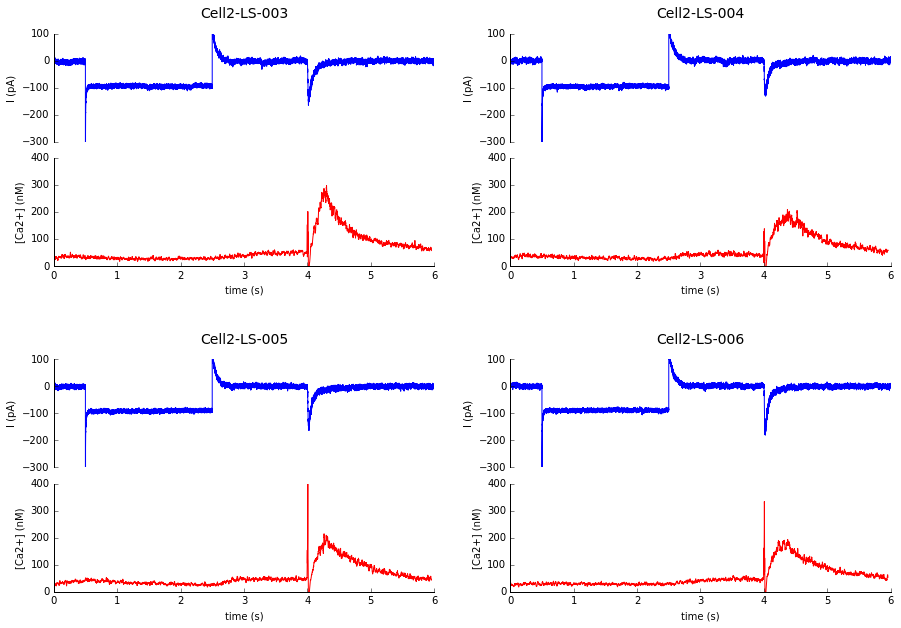

In [7]:
fig = plt.figure(figsize=(15, 10))
outer = gridspec.GridSpec(2, 2, wspace=0.2, hspace=0.4)

for i in range(4):
    inner = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=outer[i], 
                                             wspace=0.1, hspace=0.15)
    
    for j in range(2):
        ax = plt.Subplot(fig, inner[j])
        if j == 0:
            x = df_vr_list[i+2]['Time']
            y = df_vr_list[i+2]['Primary']
            ax.plot(x, y)
            ax.set_title(os.path.split(folder_list[i+2])[-1], 
                         y = 1.1, fontsize=14)
            ax.set_ylabel('I (pA)')
            ax.set_ylim(-300, 100)
            clean_plot(ax, True)
        else:
            x = df_ls_list[i+2]['Prof 1 Time']
            y = df_ls_list[i+2]['ca_conc']
            ax.plot(x, y, 'r')
            ax.set_ylabel('[Ca2+] (nM)')
            ax.set_xlabel('time (s)')
            ax.set_ylim(0, 400)
            clean_plot(ax)
        fig.add_subplot(ax)

These are the same four plots from above, except now instead of plotting the raw fluorescence values we are plotting the calculated calcium concentration values. 

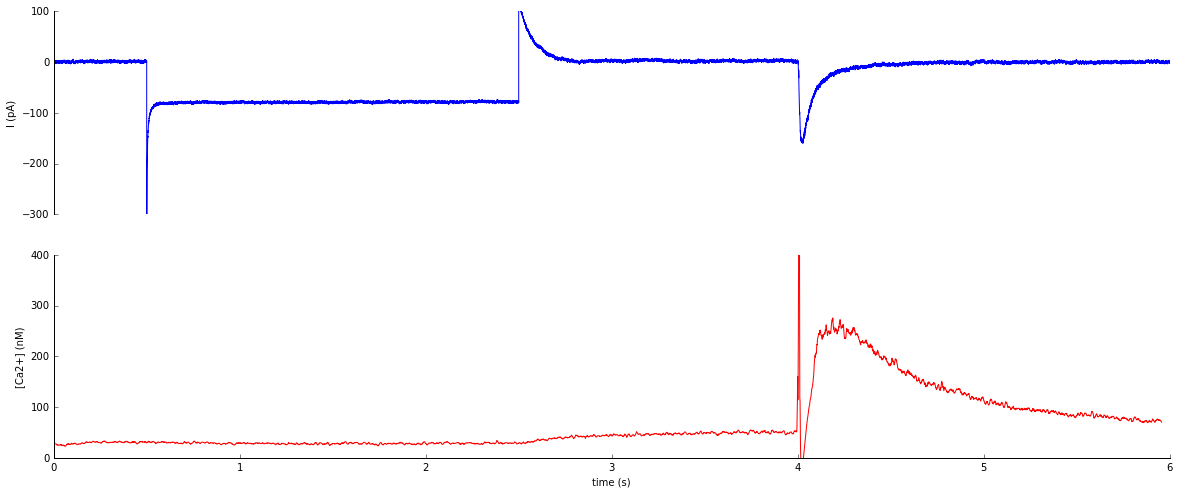

In [8]:
avg_vm = pd.concat(df_vr_list, 
                   keys=range(len(df_ls_list))).ix[2:9].groupby(level="Index").mean()['Primary']
avg_ca = pd.concat(df_ls_list, 
                   keys=range(len(df_ls_list))).ix[2:9].groupby(level="Index").mean()['ca_conc']

f, (ax1, ax2) = plt.subplots(2, sharex=True, figsize=(20, 8))

ax1.plot(df_vr_list[2]['Time'], avg_vm)
ax2.plot(df_ls_list[2]['Prof 1 Time'], avg_ca, 'r')

ax1.set_ylabel('I (pA)')
ax1.set_ylim(-300, 100)
clean_plot(ax1, True)

ax2.set_ylabel('[Ca2+] (nM)')
ax2.set_xlabel('time (s)')
ax2.set_ylim(0, 400)
clean_plot(ax2)

Averaging those four plots together, we see that this particular synaptic stimulus produces a peak change in intracellular calcium contration of roughly 275nM. 

One hypothesis our lab is interested in studying is that calcium may play a role in the neurodegeneration seen in Parkinson's disease. This experiment was a proof-of-concept that we can measure approximate changes in calcium concentration in dendrites following a synaptic stimulation. Future experiments will aim to examine how that calcium may play a role in cell death in certain populations of cells in the brain, using this technique as one of our assays for changes in intracellular concentration levels. 

### Extra functions

In [9]:
def clean_plot(ax, top=False):
    """Make the plots look a little nicer by removing some of the axes / spines"""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
    if top:
        ax.get_xaxis().set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.set_yticks(ax.get_yticks()[::2])
    else:
        ax.set_yticks(ax.get_yticks()[::2])